# Task 3 Data Science in Smart Cities

Sebastian Kampen (21875871) and Lars Kaesberg (21977731)

## Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from datetime import datetime

## Prepare Datasets

In [2]:
def get_qol_dataset(start_year, end_year, last_mid=False):
    if Path("datasets/qol_dataset.csv").exists():
        return pd.read_csv("datasets/qol_dataset.csv")

    datasets = []

    for year in range(start_year, end_year + 1):
        qol_year_dataset = pd.read_html(f"https://www.numbeo.com/quality-of-life/rankings.jsp?title={year}")[1]
        qol_year_dataset["year"] = year
        qol_year_dataset["Rank"] = qol_year_dataset.index
        datasets.append(qol_year_dataset)

        if year == end_year and not last_mid:
            break

        qol_mid_year_dataset = pd.read_html(f"https://www.numbeo.com/quality-of-life/rankings.jsp?title={year}-mid")[1]
        qol_mid_year_dataset["year"] = year + 0.5
        qol_mid_year_dataset["Rank"] = qol_mid_year_dataset.index
        datasets.append(qol_mid_year_dataset)

    pd_dataset = pd.concat(datasets)

    # Data cleanup
    location_info = [city.split(", ") for city in pd_dataset["City"]]
    pd_dataset["City"] = [location[0] for location in location_info]
    pd_dataset["State"] = [location[1] if len(location) == 3 else "" for location in location_info]
    pd_dataset["Country"] = [location[2] if len(location) == 3 else location[1] for location in location_info]
    pd_dataset.to_csv("datasets/qol_dataset.csv", index=False)

    return pd_dataset

In [3]:
def get_covid_dataset():
    dataset = pd.read_csv("datasets/owid-covid-data.csv", parse_dates=True)
    dataset.date = pd.to_datetime(dataset.date)
    return dataset

In [4]:
def get_air_quality_dataset(path):
    dataset = pd.read_csv(path, sep=";", parse_dates=True)
    dataset.Date = dataset.Date.apply(lambda x: str(x).replace("24:00", "23:59"))
    dataset = dataset.replace("-", np.nan)
    dataset["Particulate matter (PM₁₀) floating hourly daily average in µg/m³"] = dataset[
        "Particulate matter (PM₁₀) floating hourly daily average in µg/m³"].astype(float)
    dataset["Ozone (O₃) One hour average in µg/m³"] = dataset["Ozone (O₃) One hour average in µg/m³"].astype(float)
    dataset["Nitrogen dioxide (NO₂) One hour average in µg/m³"] = dataset[
        "Nitrogen dioxide (NO₂) One hour average in µg/m³"].astype(float)
    dataset.Date = pd.to_datetime(dataset.Date)
    return dataset

In [5]:
def get_nasdaq_dataset(path):
    dataset = pd.read_csv(path, parse_dates=True)
    dataset.Date = pd.to_datetime(dataset.Date)
    return dataset

In [6]:
def get_homicide_dataset():
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    dataset = pd.read_csv("datasets/Homicide Victim 2003 - September 2022.csv", parse_dates=True)
    dataset["Recorded Date"] = [f"20{date.split('-')[1]}-{(months.index(date.split('-')[0]) + 1):02d}" for date in
                                dataset["Recorded Date"]]
    dataset["Recorded Date"] = pd.to_datetime(dataset["Recorded Date"])
    return dataset.groupby(by="Recorded Date").sum()

In [7]:
def get_flight_dataset():
    dataset = pd.read_csv("datasets/Passengers_Month.csv", parse_dates=True)
    dataset = dataset.fillna(0)
    dataset["date"] = pd.to_datetime(
        [f"{year}-{month.replace('M', '')}" for year, month in zip(dataset.year, dataset.month)])
    return dataset

In [8]:
covid_dataset = get_covid_dataset()
nasdaq100_dataset = get_nasdaq_dataset("datasets/nasdaq-100-5-years.csv")
nasdaq_tech100_dataset = get_nasdaq_dataset("datasets/nasdaq-tech-100-5-years.csv")
nasdaq_health100_dataset = get_nasdaq_dataset("datasets/nasdaq-health-100-5-years.csv")
invesco_db_agriculture_dataset = get_nasdaq_dataset("datasets/invesco-db-agriculture-5-years.csv")
qol_dataset = get_qol_dataset(2020, 2023)
homicide_dataset = get_homicide_dataset()
flight_dataset = get_flight_dataset()
air_berlin_dataset = get_air_quality_dataset(
    "datasets/airquality/air-quality_DEBE068_Berlin-Mitte_2020-01-01_00-2023-01-30_18.csv")

C:\Users\Larsk\AppData\Local\Temp\ipykernel_20148\3427536979.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return dataset.groupby(by="Recorded Date").sum()


## Analyze Datasets

In [9]:
covid_dataset.describe()

total_cases     new_cases  new_cases_smoothed  total_deaths  \
count  2.351700e+05  2.348980e+05        2.336940e+05  2.156530e+05   
mean   5.025617e+06  1.208412e+04        1.212047e+04  7.804205e+04   
std    3.107973e+07  8.345950e+04        8.112209e+04  3.986949e+05   
min    1.000000e+00  0.000000e+00        0.000000e+00  1.000000e+00   
25%    5.313250e+03  0.000000e+00        5.000000e+00  1.210000e+02   
50%    5.854200e+04  4.200000e+01        8.342900e+01  1.316000e+03   
75%    6.083320e+05  8.700000e+02        1.053000e+03  1.068800e+04   
max    6.655189e+08  4.083956e+06        3.439396e+06  6.714212e+06   

          new_deaths  new_deaths_smoothed  total_cases_per_million  \
count  215556.000000        214370.000000            234100.000000   
mean      129.463754           129.992041             69381.905708   
std       701.616466           686.931500            118992.734441   
min         0.000000             0.000000                 0.001000   
25%         0.000000             0.000000              1284.354250   
50%         0.000000             1.286000             12631.890000   
75%        12.000000            14.143000             82302.501500   
max     17733.000000         14859.429000            708375.046000   

       new_cases_per_million  new_cases_smoothed_per_million  \
count          233828.000000                   232629.000000   
mean              182.949538                      183.408362   
std              1145.642161                      678.385957   
min                 0.000000                        0.000000   
25%                 0.000000                        1.062000   
50%                 5.563000                       17.129000   
75%                88.570000                      128.940000   
max            228872.025000                    36421.827000   

       total_deaths_per_million  ...   male_smokers  handwashing_facilities  \
count             214596.000000  ...  149856.000000            98749.000000   
mean                 732.983636  ...      32.817694               50.874843   
std                 1012.435055  ...      13.537943               31.869461   
min                    0.000000  ...       7.700000                1.188000   
25%                   32.408250  ...      21.600000               20.859000   
50%                  236.969000  ...      33.100000               49.839000   
75%                 1087.422500  ...      41.300000               83.241000   
max                 6414.586000  ...      78.100000              100.000000   

       hospital_beds_per_thousand  life_expectancy  human_development_index  \
count               178554.000000    228741.000000            195741.000000   
mean                     3.087639        73.605294                 0.724616   
std                      2.550900         7.446974                 0.149594   
min                      0.100000        53.280000                 0.394000   
25%                      1.300000        69.500000                 0.602000   
50%                      2.500000        75.050000                 0.742000   
75%                      4.200000        79.070000                 0.838000   
max                     13.800000        86.750000                 0.957000   

         population  excess_mortality_cumulative_absolute  \
count  2.482500e+05                          8.241000e+03   
mean   1.407191e+08                          5.016443e+04   
std    6.921872e+08                          1.381035e+05   
min    4.700000e+01                         -3.772610e+04   
25%    8.367830e+05                          6.200000e+01   
50%    6.948395e+06                          6.465400e+03   
75%    3.369661e+07                          3.644650e+04   
max    7.975105e+09                          1.240196e+06   

       excess_mortality_cumulative  excess_mortality  \
count                  8241.000000       8280.000000   
mean                     10.143572         14.099836   
std               

In [10]:
nasdaq100_dataset.describe()

Close/Last          Open          High           Low
count   1258.000000   1258.000000   1258.000000   1258.000000
mean   10456.374547  10455.724960  10540.946216  10362.280835
std     3065.959151   3067.935087   3090.529909   3038.159052
min     5899.350000   5969.080000   6075.170000   5895.120000
25%     7495.710000   7498.750000   7551.335000   7436.327500
50%    10635.840000  10592.135000  10692.215000  10527.535000
75%    13071.875000  13065.140000  13234.327500  12944.985000
max    16573.340000  16644.770000  16764.860000  16523.830000

In [11]:
nasdaq_tech100_dataset.describe()

Close/Last         Open         High          Low
count  1258.000000  1258.000000  1258.000000  1258.000000
mean   6079.523156  6079.336248  6138.643180  6015.520326
std    1713.487433  1714.875828  1730.941261  1693.444353
min    3457.920000  3494.810000  3557.780000  3451.910000
25%    4439.800000  4446.770000  4479.907500  4410.337500
50%    5806.030000  5822.745000  5874.690000  5744.705000
75%    7543.992500  7567.537500  7675.490000  7483.975000
max    9855.420000  9888.600000  9926.870000  9836.710000

In [12]:
nasdaq_health100_dataset.describe()

Close/Last         Open         High          Low
count  1258.000000  1258.000000  1258.000000  1258.000000
mean    952.459716   952.694858   960.479734   943.727625
std     169.594054   169.850779   170.415690   168.641532
min     671.221400   675.430800   683.784000   668.354500
25%     814.555550   814.877900   820.812875   807.123125
50%     895.871950   896.375200   903.892800   889.865000
75%    1063.667500  1064.607500  1072.350000  1056.045000
max    1356.390000  1372.990000  1378.270000  1352.930000

In [13]:
invesco_db_agriculture_dataset.describe()

Close/Last        Volume         Open         High          Low
count  1258.000000  1.258000e+03  1258.000000  1258.000000  1258.000000
mean     17.620922  9.697884e+05    17.626371    17.704704    17.537316
std       2.266627  1.054325e+06     2.267569     2.278555     2.253752
min      13.160000  7.610600e+04    13.240000    13.320000    13.150000
25%      16.042500  3.500360e+05    16.050000    16.090025    15.972875
50%      17.295000  6.482780e+05    17.300000    17.370000    17.240000
75%      19.350000  1.211886e+06    19.375000    19.426750    19.297500
max      22.960000  1.129697e+07    22.750000    23.010000    22.700000

In [14]:
homicide_dataset.describe()

Count of Victims
count        237.000000
mean          11.683544
std            4.390507
min            4.000000
25%            8.000000
50%           11.000000
75%           14.000000
max           30.000000

In [15]:
qol_dataset.describe(include="all")

Rank      City  Quality of Life Index  Purchasing Power Index  \
count   1709.000000      1709            1709.000000             1709.000000   
unique          NaN       260                    NaN                     NaN   
top             NaN  San Jose                    NaN                     NaN   
freq            NaN        14                    NaN                     NaN   
mean     121.714453       NaN             140.754184               72.031539   
std       70.740515       NaN              35.377795               34.184849   
min        0.000000       NaN               0.000000                2.400000   
25%       61.000000       NaN             115.700000               40.900000   
50%      122.000000       NaN             145.400000               71.900000   
75%      183.000000       NaN             169.100000               98.000000   
max      254.000000       NaN             225.300000              173.000000   

        Safety Index  Health Care Index  Cost of Living Index  \
count    1709.000000        1709.000000           1709.000000   
unique           NaN                NaN                   NaN   
top              NaN                NaN                   NaN   
freq             NaN                NaN                   NaN   
mean       56.620772          66.954067             57.599707   
std        15.174584           9.491997             20.800234   
min        15.100000          38.400000             18.700000   
25%        46.500000          60.600000             38.600000   
50%        57.300000          67.900000             61.100000   
75%        69.100000          74.300000             73.200000   
max        92.600000          87.400000            135.500000   

        Property Price to Income Ratio  Traffic Commute Time Index  \
count                      1709.000000                 1709.000000   
unique                             NaN                         NaN   
top                                NaN                         NaN   
freq                               NaN                         NaN   
mean                         11.399883                   36.168169   
std                           8.743309                    8.952812   
min                           1.000000                   16.100000   
25%                           6.000000                   29.700000   
50%                           9.900000                   35.000000   
75%                          14.200000                   41.200000   
max                         150.600000                   68.200000   

        Pollution Index  Climate Index         year State        Country  
count       1709.000000    1709.000000  1709.000000   334           1709  
unique              NaN            NaN          NaN    31             91  
top                 NaN            NaN          NaN    CA  United States  
freq                NaN            NaN          NaN    42            332  
mean          50.497718      77.173610  2021.516091   NaN            NaN  
std           20.742767      17.361715     0.990088   NaN            NaN  
min           12.700000      14.300000  2020.000000   NaN            NaN  
25%           33.100000      67.100000  2020.500000   NaN            NaN  
50%           49.700000      81.500000  2021.500000   NaN            NaN  
75%           66.000000      89.800000  2022.500000   NaN            NaN  
max           95.900000      99.900000  2023.000000   NaN            NaN

In [16]:
air_berlin_dataset.describe()

Particulate matter (PM₁₀) floating hourly daily average in µg/m³  \
count                                       26246.000000                  
mean                                           18.229216                  
std                                             8.868745                  
min                                             5.000000                  
25%                                            12.000000                  
50%                                            16.000000                  
75%                                            22.000000                  
max                                            89.000000                  

       Ozone (O₃) One hour average in µg/m³  \
count                                   0.0   
mean                                    NaN   
std                                     NaN   
min                                     NaN   
25%                                     NaN   
50%                                     NaN   
75%                                     NaN   
max                                     NaN   

       Nitrogen dioxide (NO₂) One hour average in µg/m³  
count                                      26726.000000  
mean                                          17.267099  
std                                           11.959273  
min                                            0.500000  
25%                                            9.000000  
50%                                           14.000000  
75%                                           22.000000  
max                                          116.000000

In [17]:
flight_dataset.describe()

year    passengers
count  37065.000000  3.706500e+04
mean    2007.212465  1.354376e+06
std        8.494249  3.230155e+06
min     1993.000000  0.000000e+00
25%     2000.000000  0.000000e+00
50%     2007.000000  4.684400e+04
75%     2015.000000  1.205318e+06
max     2022.000000  2.915027e+07

## Utils

In [18]:
def double_plot(title, xlabel, ylabel, ylabel2, data_x, data_y):
    plt.title(title)
    plt.grid(False)
    plt.xticks(rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel, color="b")
    sns.lineplot(data=data_x, color="b")
    plt.twinx()
    plt.grid(False)
    plt.ylabel(ylabel2, color="r")
    sns.lineplot(data=data_y, color="r")

In [19]:
def analyze_results(regressor, test_data, true_labels):
    predictions = regressor.predict(test_data)
    mse = mean_absolute_error(true_labels, predictions)
    score = regressor.score(test_data, true_labels)
    print(f"MSE: {mse}, SCORE: {score}")

## Quality of Life during Corona

In [20]:
covid_dataset[["new_deaths_smoothed", "new_vaccinations_smoothed", "new_tests_smoothed"]].describe()

new_deaths_smoothed  new_vaccinations_smoothed  new_tests_smoothed
count        214370.000000               1.486220e+05        1.039650e+05
mean            129.992041               3.619419e+05        1.421784e+05
std             686.931500               2.193245e+06        1.138215e+06
min               0.000000               0.000000e+00        0.000000e+00
25%               0.000000               5.120000e+02        1.486000e+03
50%               1.286000               5.648000e+03        6.570000e+03
75%              14.143000               4.249775e+04        3.220500e+04
max           14859.429000               4.369095e+07        1.476998e+07

In [21]:
def qol(country = None):
    def format_year(unformatted_year: float):
        '''
        Unformatted year is a float with the following format: 
        yyyy.[relative month of year]

        It will be transformed to a datetime.
        '''
        part_of_year = unformatted_year % 1.0
        year = int(unformatted_year)
        month = int(part_of_year * 11 + 1)
        
        return datetime(year, month, 1)
    covid_dataset_prepared = covid_dataset.interpolate(method='pad')

    if country: 
        tmp_qol = qol_dataset[qol_dataset.Country == country].groupby(by=["year"]).mean()
        tmp_qol = tmp_qol.set_index(tmp_qol.index.map(format_year))
        tmp_qol_covid = tmp_qol.join(covid_dataset_prepared[covid_dataset_prepared.location == country].groupby("date").mean(numeric_only=True))
        # print(tmp_qol_covid['stringency_index'])
    else:
        tmp_qol = qol_dataset.groupby(by="year").mean()    
        tmp_qol = tmp_qol.set_index(tmp_qol.index.map(format_year))
        tmp_qol_covid = tmp_qol.join(covid_dataset_prepared.groupby("date").mean(numeric_only=True))
    
    tmp_qol_covid_corr = tmp_qol_covid.corr()['Quality of Life Index'].sort_values(ascending=False)
    print("Stringency Correlation:", tmp_qol_covid_corr["stringency_index"])
    print("New Deaths Correlation:", tmp_qol_covid_corr["new_deaths"])
    plt.rcParams["figure.figsize"] = (17,5)
    plt.subplot(1, 2, 1)
    double_plot(
        f"Quality of Life during Corona{' '+country if country else '' }",
        "Date", 
        "Quality of Life", 
        "Stringency",
        tmp_qol_covid["Quality of Life Index"],
        (covid_dataset_prepared[covid_dataset_prepared.location == country] if country else covid_dataset_prepared).groupby("date").mean(numeric_only=True)["stringency_index"]
    )

    plt.subplot(1, 2, 2)
    double_plot(
        f"Deaths during Corona{' '+country if country else '' }",
        "Date", 
        "Quality of Life", 
        "New Deaths",
        tmp_qol_covid["Quality of Life Index"],
        (covid_dataset_prepared[covid_dataset_prepared.location == country] if country else covid_dataset_prepared).groupby("date").mean(numeric_only=True)["new_deaths"]
    )
    plt.rcParams["figure.figsize"] = (8,5)

C:\Users\Larsk\AppData\Local\Temp\ipykernel_20148\2961914160.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_qol = qol_dataset.groupby(by="year").mean()


Stringency Correlation: -0.618598267507428
New Deaths Correlation: -0.8372246416326928


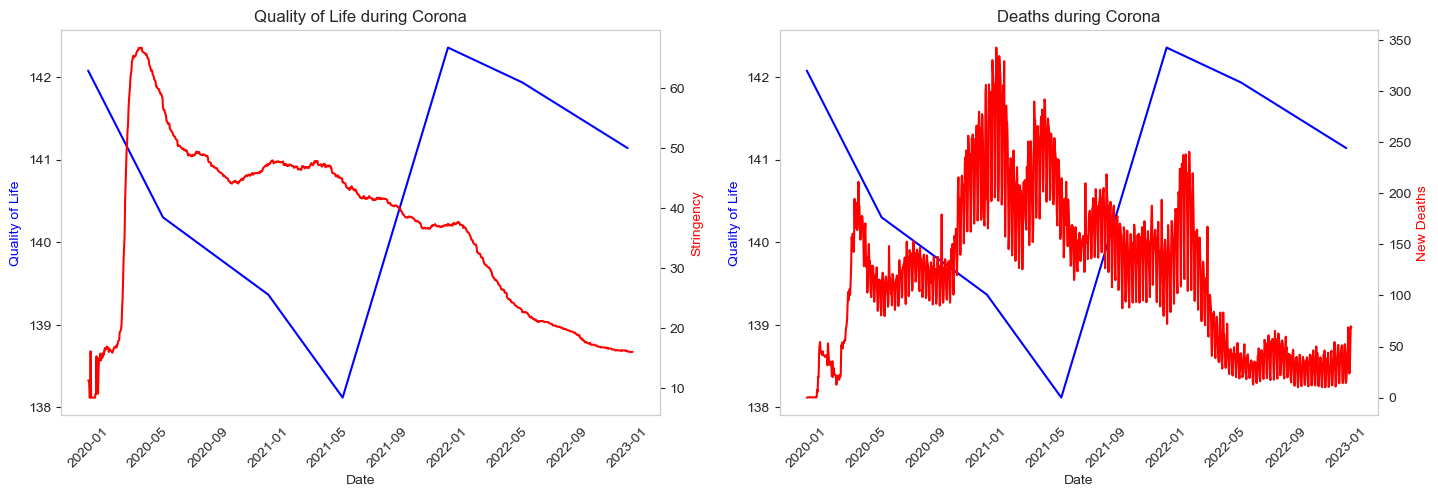

In [22]:
qol()

C:\Users\Larsk\AppData\Local\Temp\ipykernel_20148\2961914160.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_qol = qol_dataset[qol_dataset.Country == country].groupby(by=["year"]).mean()


Stringency Correlation: -0.7959094570918723
New Deaths Correlation: -0.4587402148832522


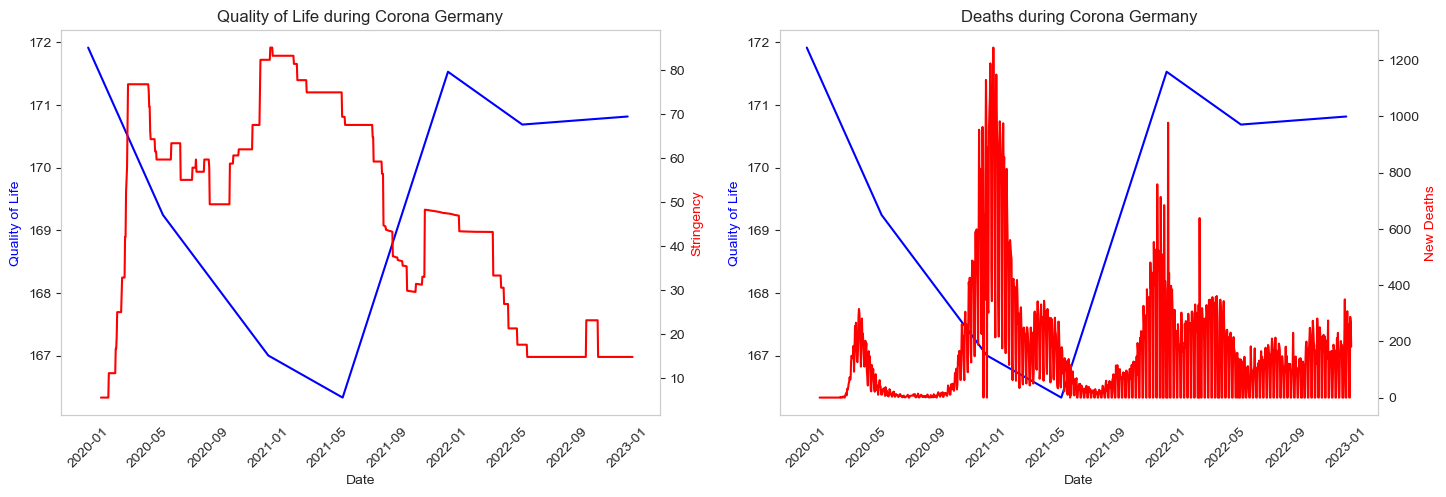

In [23]:
qol("Germany")

C:\Users\Larsk\AppData\Local\Temp\ipykernel_20148\2961914160.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_qol = qol_dataset[qol_dataset.Country == country].groupby(by=["year"]).mean()


Stringency Correlation: -0.9091026158498436
New Deaths Correlation: -0.43976552556934484


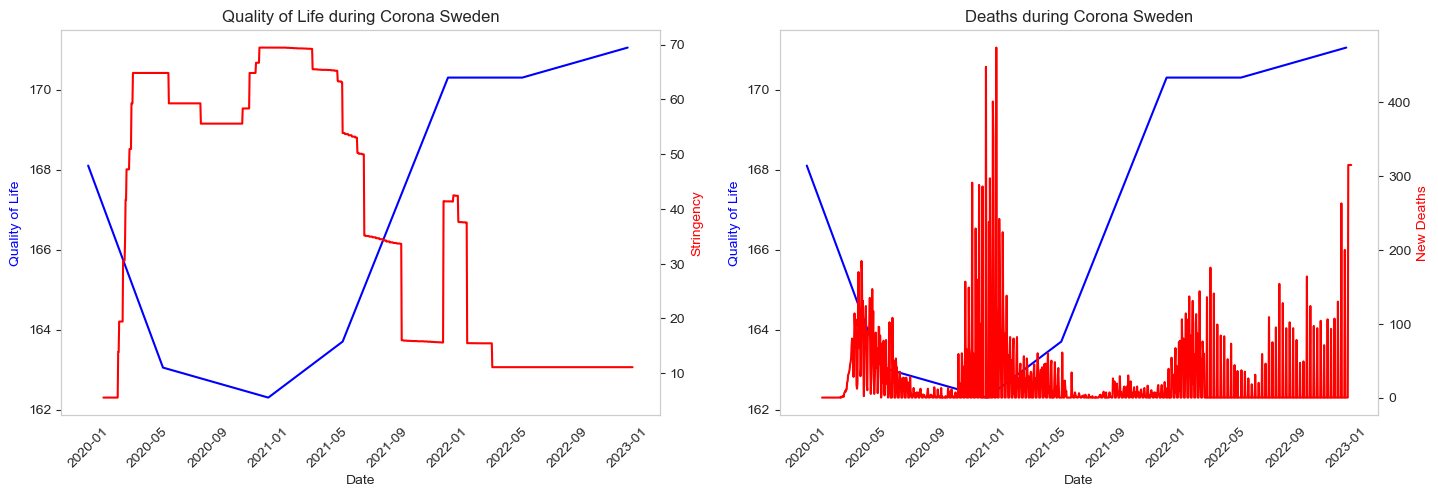

In [24]:
qol("Sweden")

C:\Users\Larsk\AppData\Local\Temp\ipykernel_20148\2961914160.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_qol = qol_dataset[qol_dataset.Country == country].groupby(by=["year"]).mean()


Stringency Correlation: -0.3878821754547439
New Deaths Correlation: -0.03741036478627946


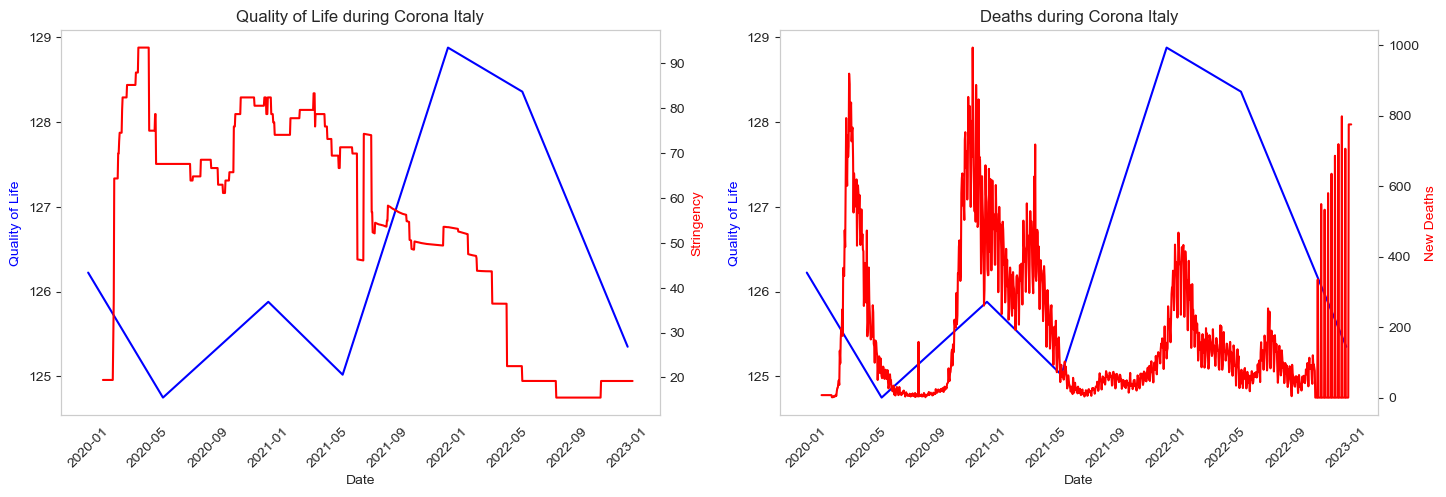

In [25]:
qol("Italy")

C:\Users\Larsk\AppData\Local\Temp\ipykernel_20148\2961914160.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_qol = qol_dataset[qol_dataset.Country == country].groupby(by=["year"]).mean()


Stringency Correlation: -0.8809032555163497
New Deaths Correlation: 0.3155203343705622


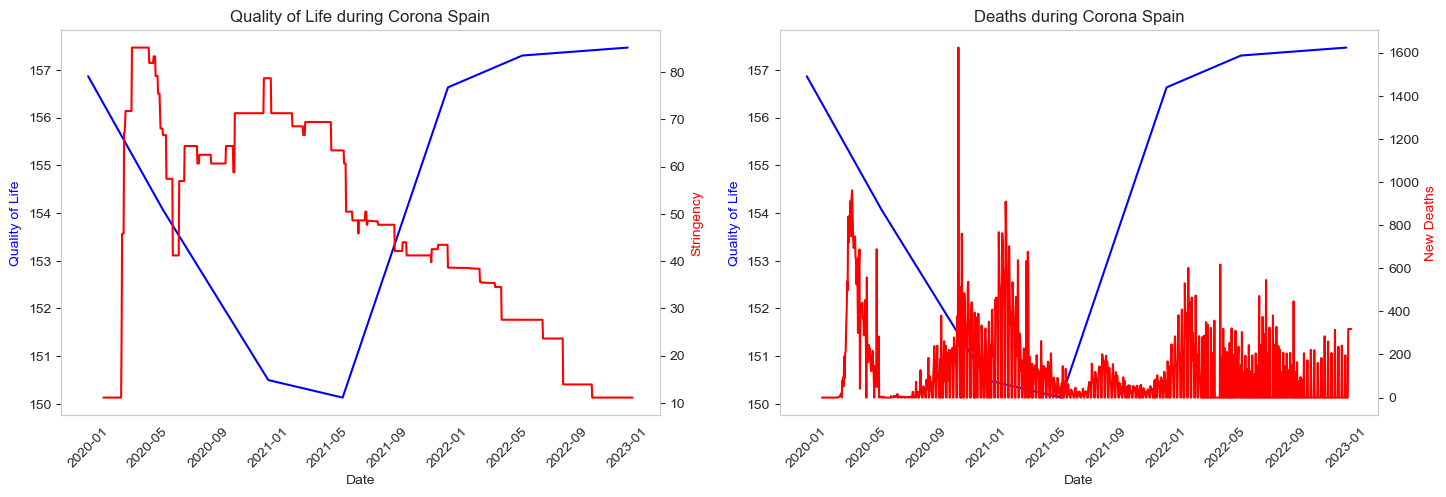

In [26]:
qol("Spain")

C:\Users\Larsk\AppData\Local\Temp\ipykernel_20148\2961914160.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_qol = qol_dataset[qol_dataset.Country == country].groupby(by=["year"]).mean()


Stringency Correlation: -0.36624434373701853
New Deaths Correlation: 0.005645467900191329


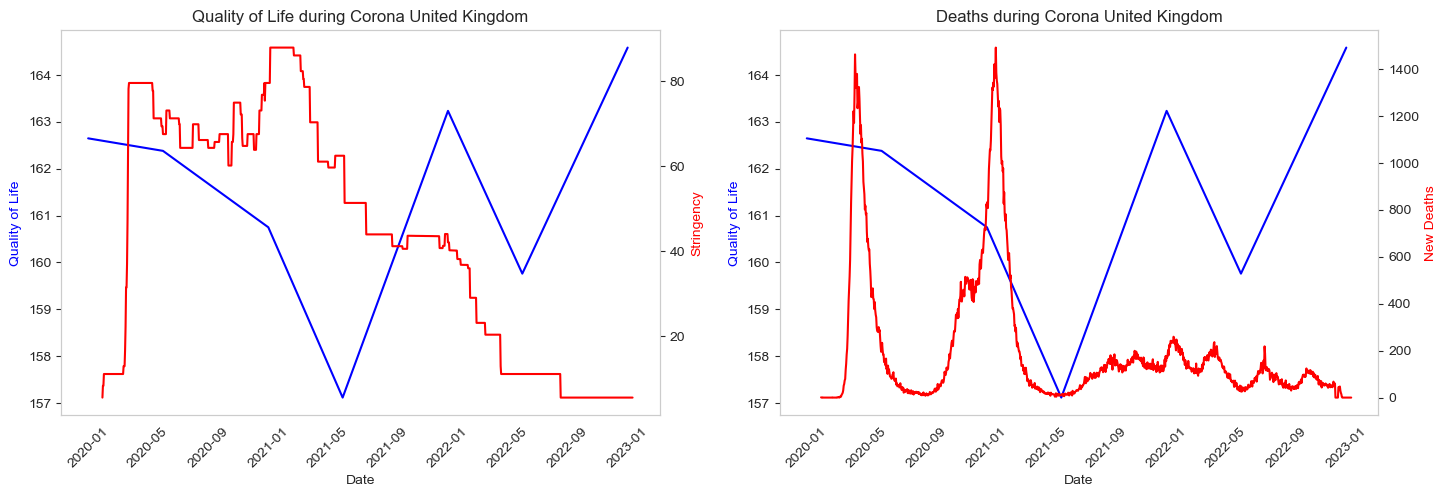

In [27]:
qol("United Kingdom")

C:\Users\Larsk\AppData\Local\Temp\ipykernel_20148\2961914160.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_qol = qol_dataset[qol_dataset.Country == country].groupby(by=["year"]).mean()


Stringency Correlation: -0.7363289651696856
New Deaths Correlation: -0.7854972335356124


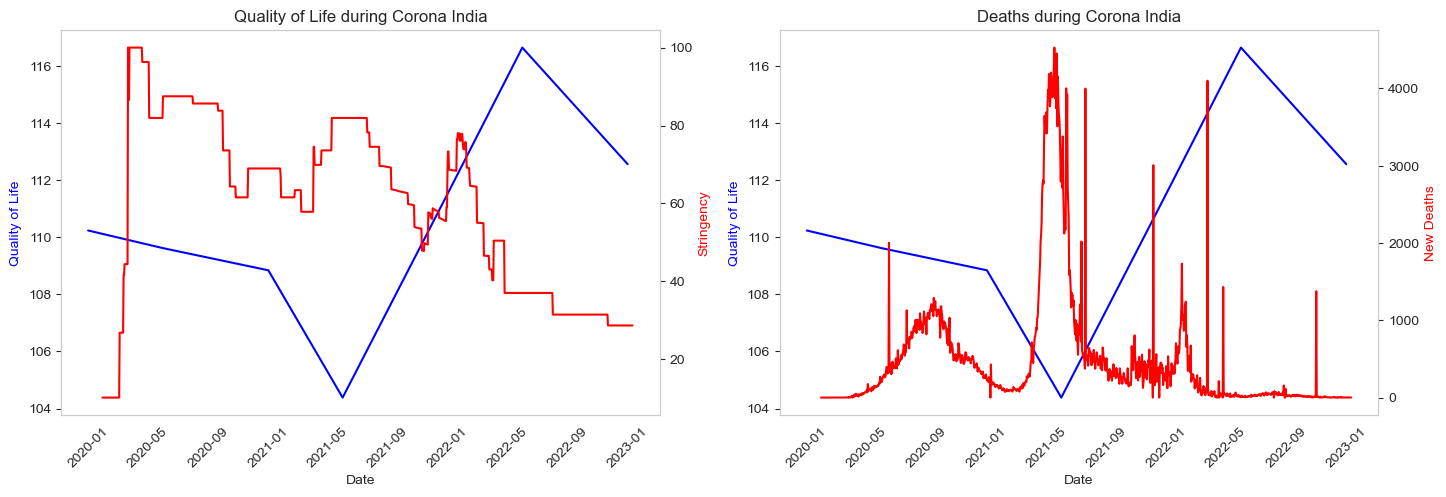

In [28]:
qol("India")

C:\Users\Larsk\AppData\Local\Temp\ipykernel_20148\2961914160.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_qol = qol_dataset[qol_dataset.Country == country].groupby(by=["year"]).mean()


Stringency Correlation: -0.4214077710841736
New Deaths Correlation: -0.8087030103430106


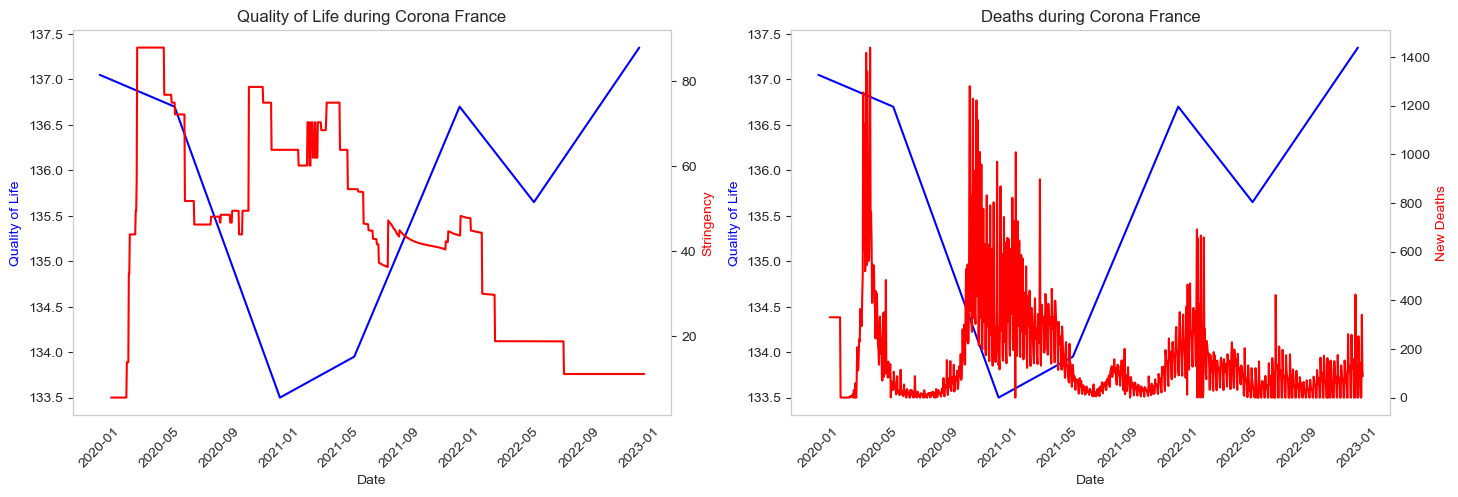

In [29]:
qol("France")

C:\Users\Larsk\AppData\Local\Temp\ipykernel_20148\2961914160.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_qol = qol_dataset[qol_dataset.Country == country].groupby(by=["year"]).mean()


Stringency Correlation: -0.3329211588302401
New Deaths Correlation: -0.45968299988791933


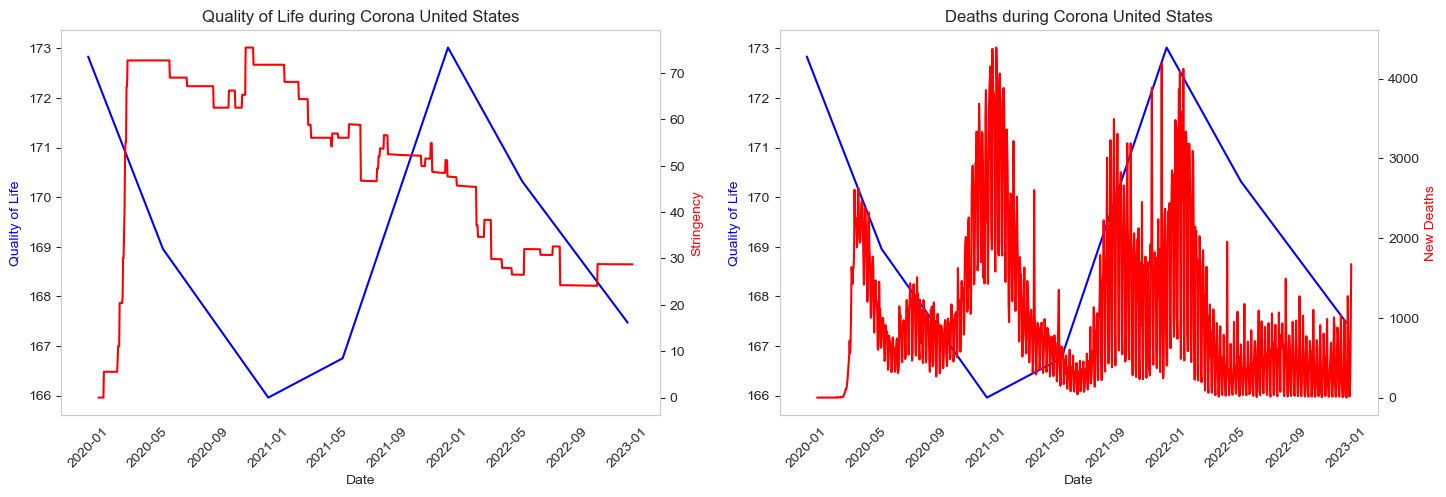

In [30]:
qol("United States")

C:\Users\Larsk\AppData\Local\Temp\ipykernel_20148\2961914160.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_qol = qol_dataset[qol_dataset.Country == country].groupby(by=["year"]).mean()


Stringency Correlation: -0.15275859339396297
New Deaths Correlation: -0.06439081904737061


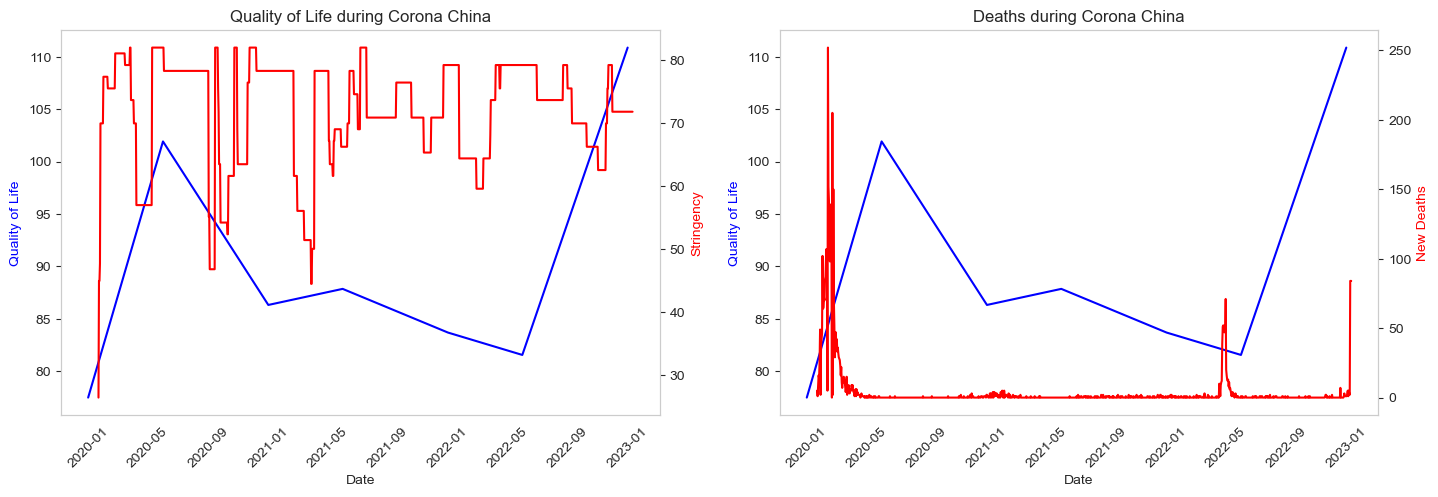

In [31]:
qol("China")

## NASDAQ during Corona

In [32]:
def nasdaq_correlation_and_regression(nasdaq_dataset, correlation_by="new_vaccinations_smoothed", continent=None, title = "NASDAQ during Corona"):
    if not continent:
        nasdaq_covid_dataset = covid_dataset.groupby("date").sum(numeric_only=True).join(
            nasdaq_dataset.set_index("Date"), on="date")
    else:
        nasdaq_covid_dataset = covid_dataset[covid_dataset.continent == continent].groupby("date").sum(
            numeric_only=True).join(nasdaq_dataset.set_index("Date"), on="date")
    nasdaq_covid_dataset = nasdaq_covid_dataset.dropna()
    nasdaq_covid_dataset = nasdaq_covid_dataset.drop(["High", "Low", "Close/Last"], axis=1)

    corr = nasdaq_covid_dataset.corr(numeric_only=True)["Open"]
    corr = corr.reindex(corr.abs().sort_values(ascending=False).index)

    print(f"Correlations with Open nasdaq value and {correlation_by}:", corr[correlation_by])


    highest_corr = corr.index[1]

    print(f"Highest correlations with Open nasdaq value: ({corr.index[1]}) {corr[1]}")

    if highest_corr == correlation_by:
        double_plot(title, 'Date', 'Open price in $', correlation_by,
                    nasdaq_covid_dataset["Open"],
                    nasdaq_covid_dataset[correlation_by])
    else:
        plt.rcParams["figure.figsize"] = (19,5)
        plt.subplot(1, 2, 1)
        double_plot(title, 'Date', 'Open price in $', correlation_by,
                    nasdaq_covid_dataset["Open"],
                    nasdaq_covid_dataset[correlation_by])

        plt.subplot(1, 2, 2)
        double_plot(title, 'Date', 'Open price in $', corr.index[1],
                    nasdaq_covid_dataset["Open"],
                    nasdaq_covid_dataset[corr.index[1]])

        plt.rcParams["figure.figsize"] = (8,5)

    X_train, X_test, y_train, y_test = train_test_split(nasdaq_covid_dataset[["new_deaths", "new_tests", "new_vaccinations"]],
                                                        nasdaq_covid_dataset["Open"], test_size=0.2, random_state=42)
    reg = RandomForestRegressor(max_depth=3).fit(X_train, y_train)
    print()
    print("RandomForestRegressor:")
    analyze_results(reg, X_test, y_test)

Correlations with Open nasdaq value and new_vaccinations_smoothed: 0.823381161828731
Highest correlations with Open nasdaq value: (new_vaccinations_smoothed) 0.823381161828731

RandomForestRegressor:
MSE: 551.820163504878, SCORE: 0.9074612492799244


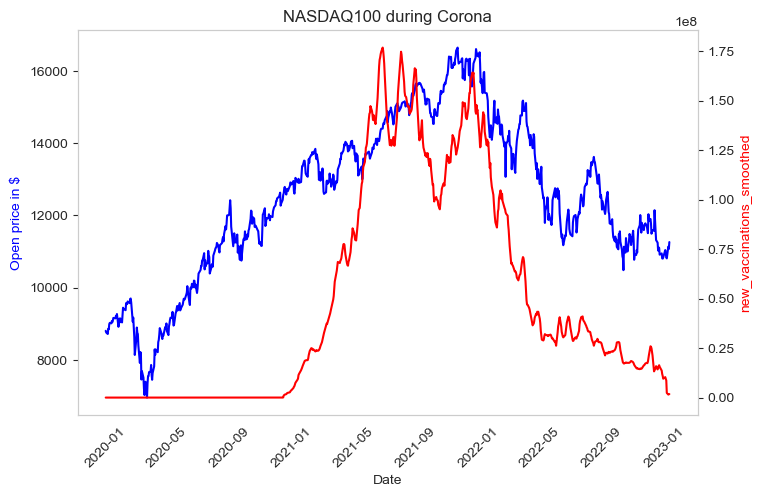

In [33]:
nasdaq_correlation_and_regression(nasdaq100_dataset, title="NASDAQ100 during Corona")

Correlations with Open nasdaq value and new_vaccinations_smoothed: 0.837225807273394
Highest correlations with Open nasdaq value: (new_tests_smoothed_per_thousand) 0.8494635285799476

RandomForestRegressor:
MSE: 386.93239456903376, SCORE: 0.8841596427030703


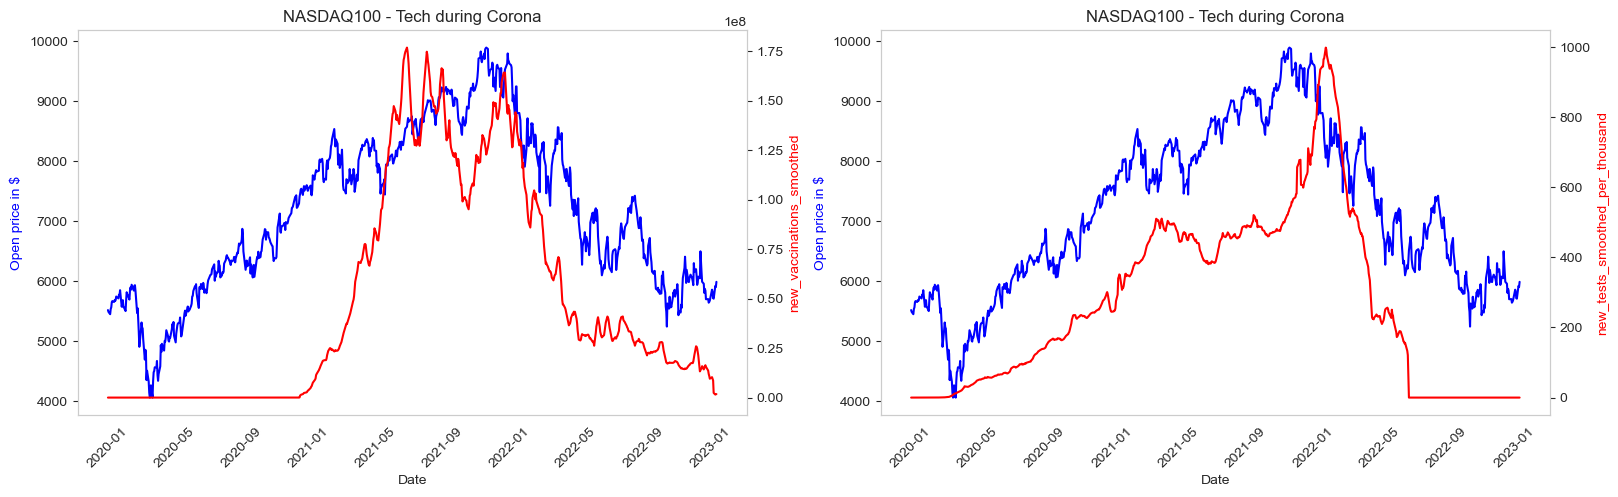

In [34]:
nasdaq_correlation_and_regression(nasdaq_tech100_dataset, title="NASDAQ100 - Tech during Corona")

Correlations with Open nasdaq value and new_vaccinations_smoothed: 0.5589394782735448
Highest correlations with Open nasdaq value: (new_deaths_smoothed) 0.8018031749657293

RandomForestRegressor:
MSE: 51.54361362292135, SCORE: 0.7997293114214293


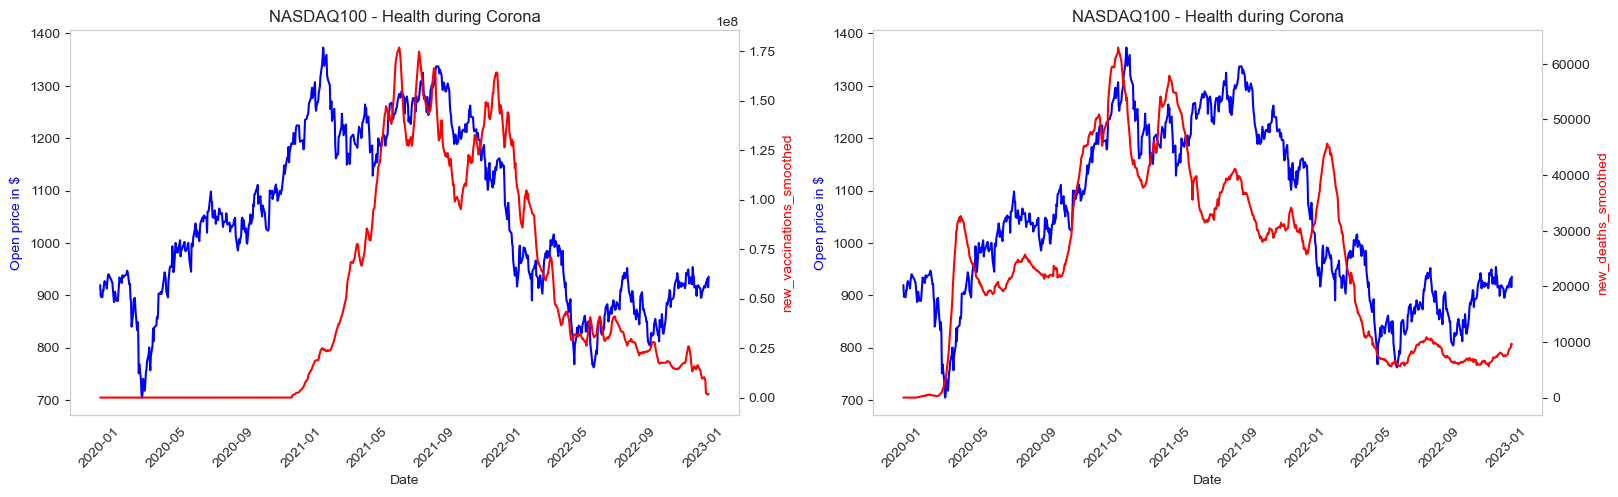

In [35]:
nasdaq_correlation_and_regression(nasdaq_health100_dataset, title="NASDAQ100 - Health during Corona")

Correlations with Open nasdaq value and new_vaccinations_smoothed: 0.48669491639462226
Highest correlations with Open nasdaq value: (total_deaths) 0.9417148793577403

RandomForestRegressor:
MSE: 0.4759668152897787, SCORE: 0.9313880606313337


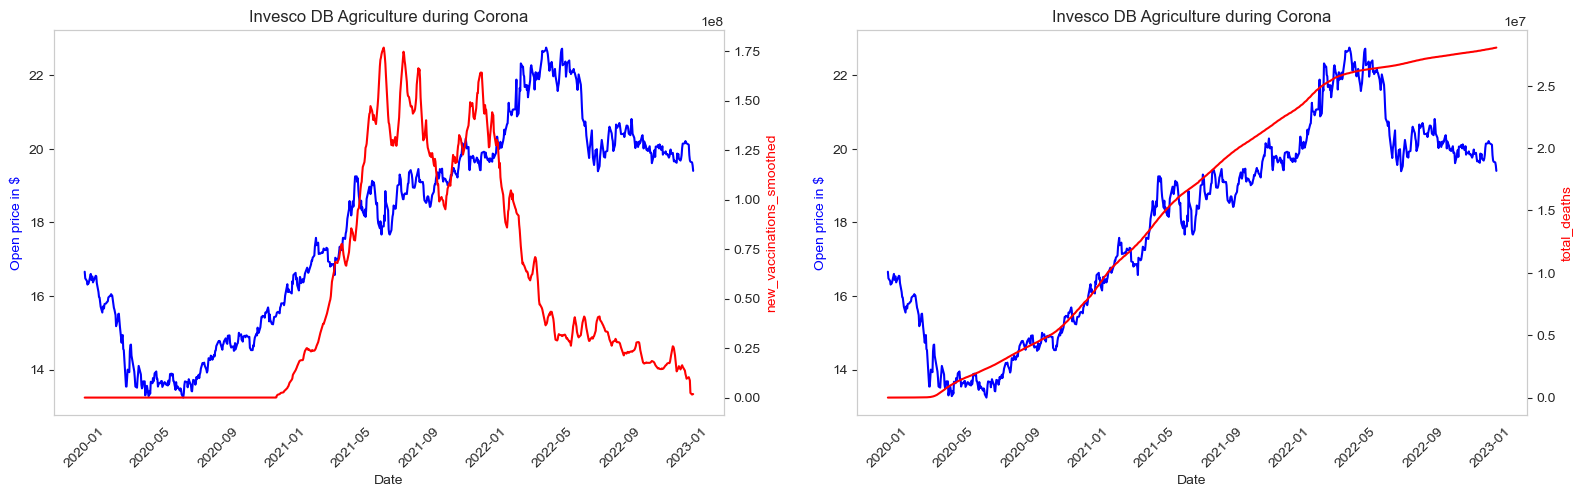

In [36]:
nasdaq_correlation_and_regression(invesco_db_agriculture_dataset, title="Invesco DB Agriculture during Corona")

Correlations with Open nasdaq value and new_vaccinations_smoothed: 0.8035712018481372
Highest correlations with Open nasdaq value: (new_vaccinations_smoothed_per_million) 0.8263796006725547

RandomForestRegressor:
MSE: 568.7924355343107, SCORE: 0.8959676943755785


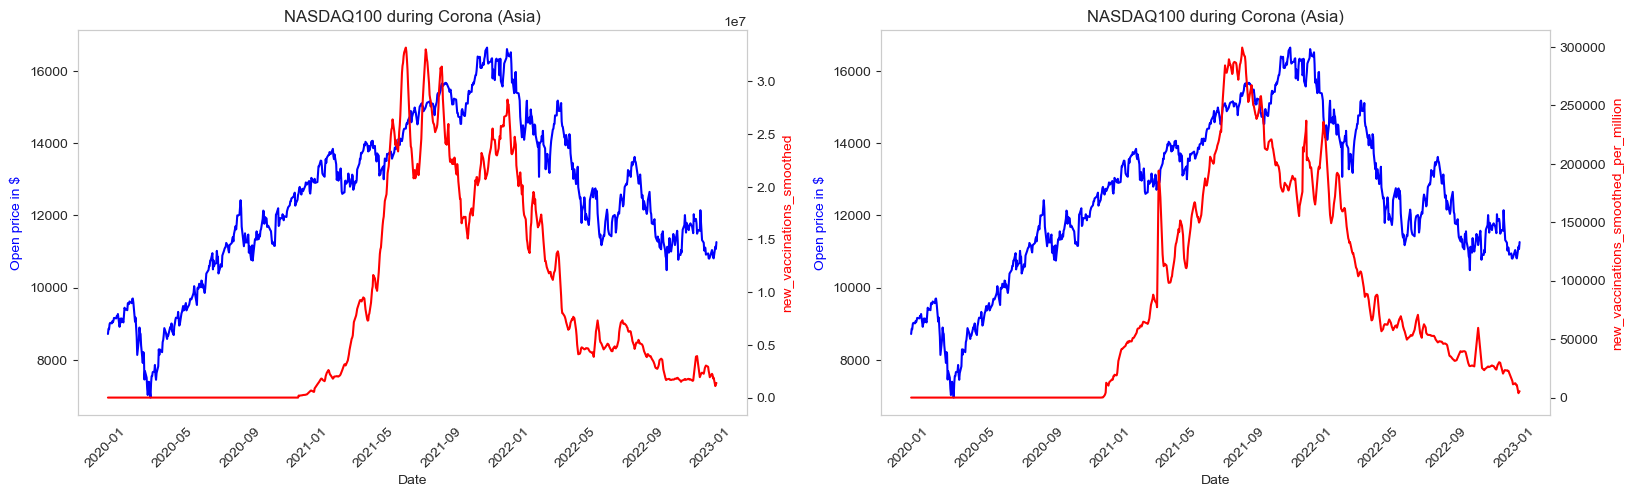

In [37]:
nasdaq_correlation_and_regression(nasdaq100_dataset, continent="Asia", title="NASDAQ100 during Corona (Asia)")

Correlations with Open nasdaq value and new_vaccinations_smoothed: 0.702681979913564
Highest correlations with Open nasdaq value: (new_tests_smoothed) 0.7937838569474588

RandomForestRegressor:
MSE: 672.4683891636985, SCORE: 0.8488684850152043


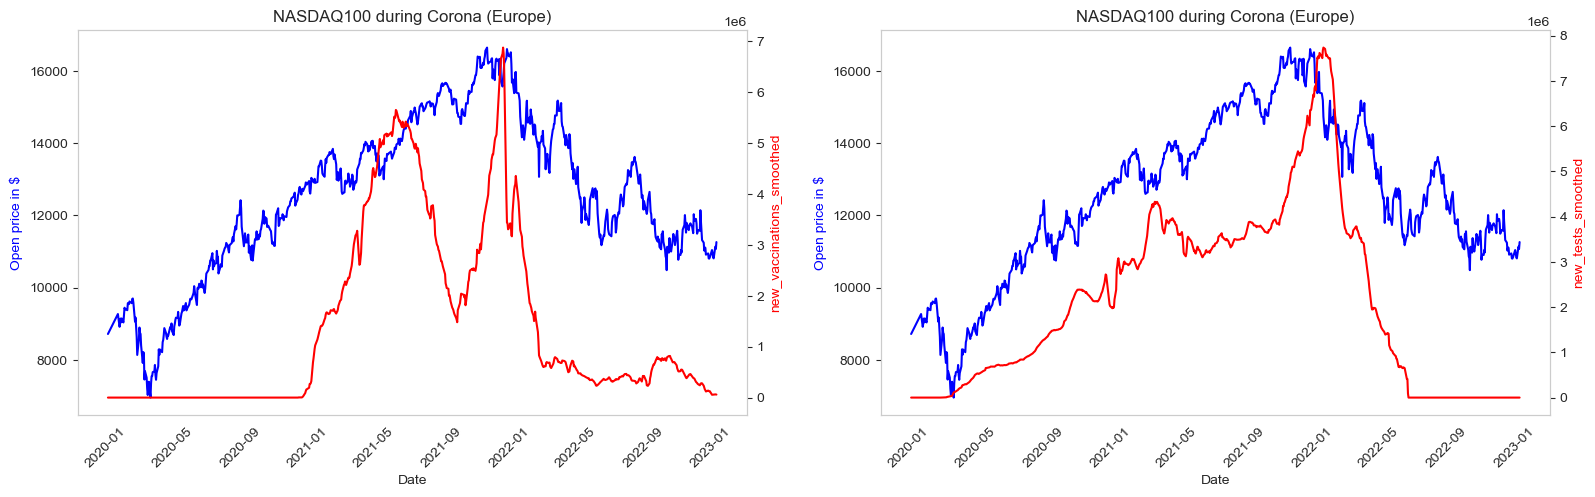

In [38]:
nasdaq_correlation_and_regression(nasdaq100_dataset, continent="Europe", title="NASDAQ100 during Corona (Europe)")

Correlations with Open nasdaq value and new_vaccinations_smoothed: 0.5972484614965282
Highest correlations with Open nasdaq value: (new_vaccinations_smoothed_per_million) 0.7994678739927903

RandomForestRegressor:
MSE: 736.4149033744688, SCORE: 0.8252676091265136


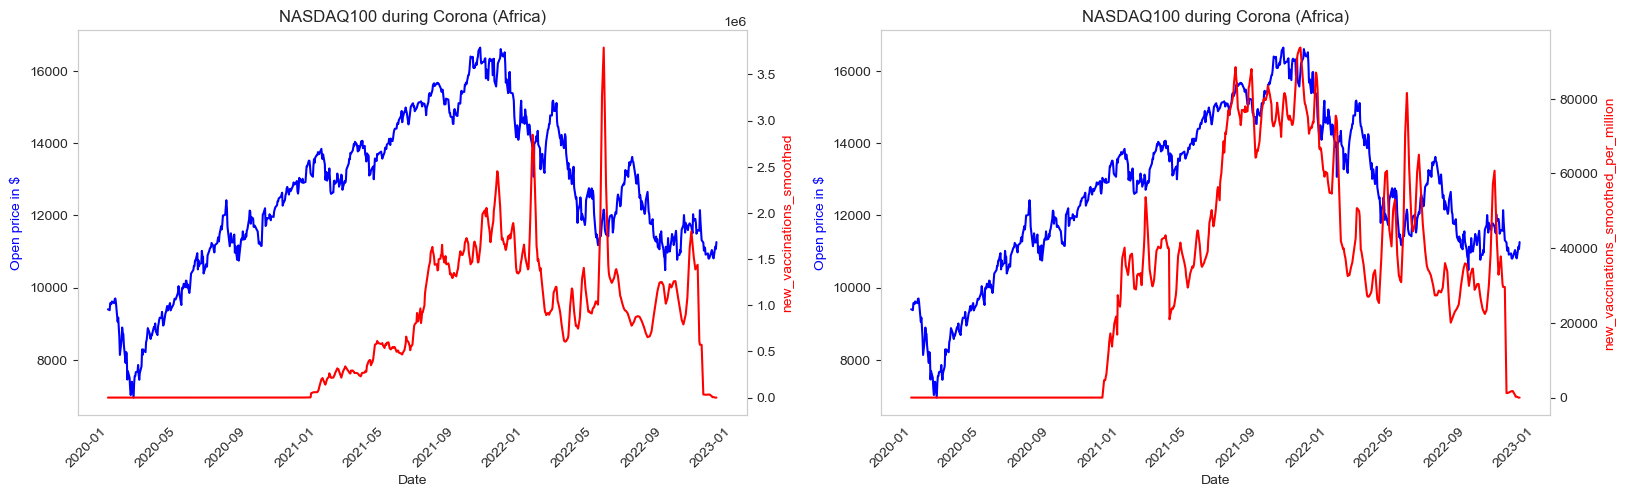

In [39]:
nasdaq_correlation_and_regression(nasdaq100_dataset, continent="Africa", title="NASDAQ100 during Corona (Africa)")

Correlations with Open nasdaq value and new_vaccinations_smoothed: 0.7228453094076329
Highest correlations with Open nasdaq value: (total_tests) 0.7469534134876116

RandomForestRegressor:
MSE: 672.7403813091885, SCORE: 0.8702083855457741


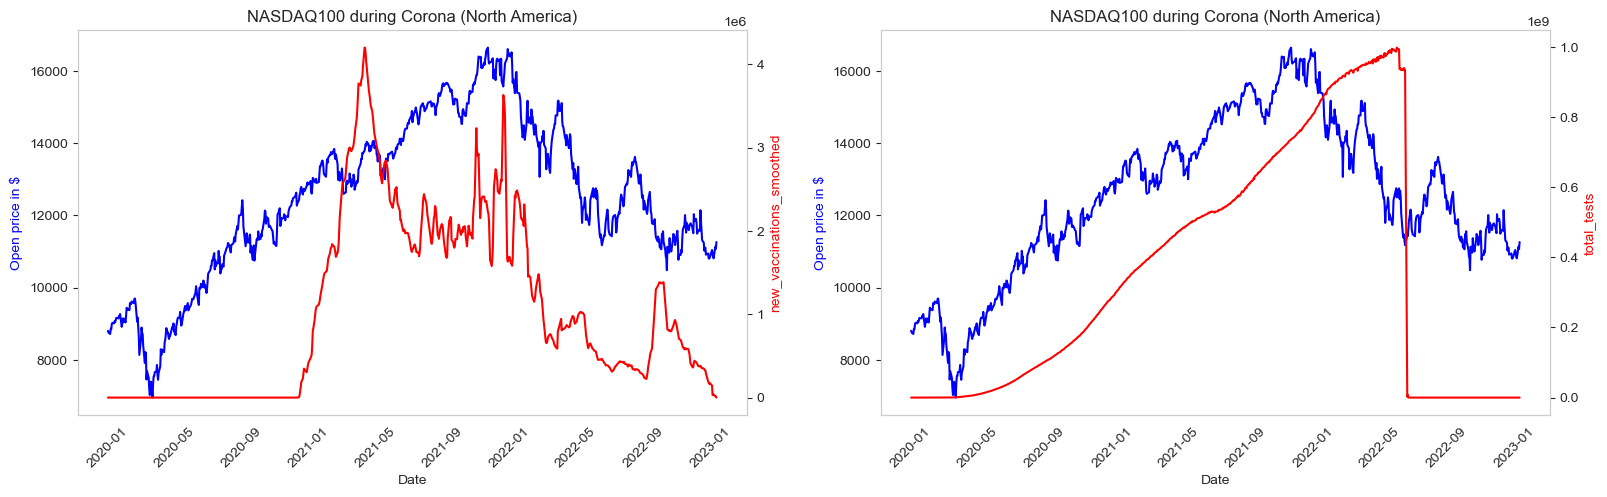

In [40]:
nasdaq_correlation_and_regression(nasdaq100_dataset, continent="North America", title="NASDAQ100 during Corona (North America)")

Correlations with Open nasdaq value and new_vaccinations_smoothed: 0.808378708239003
Highest correlations with Open nasdaq value: (total_tests) 0.8128634111934643

RandomForestRegressor:
MSE: 656.820835926508, SCORE: 0.8663827822323283


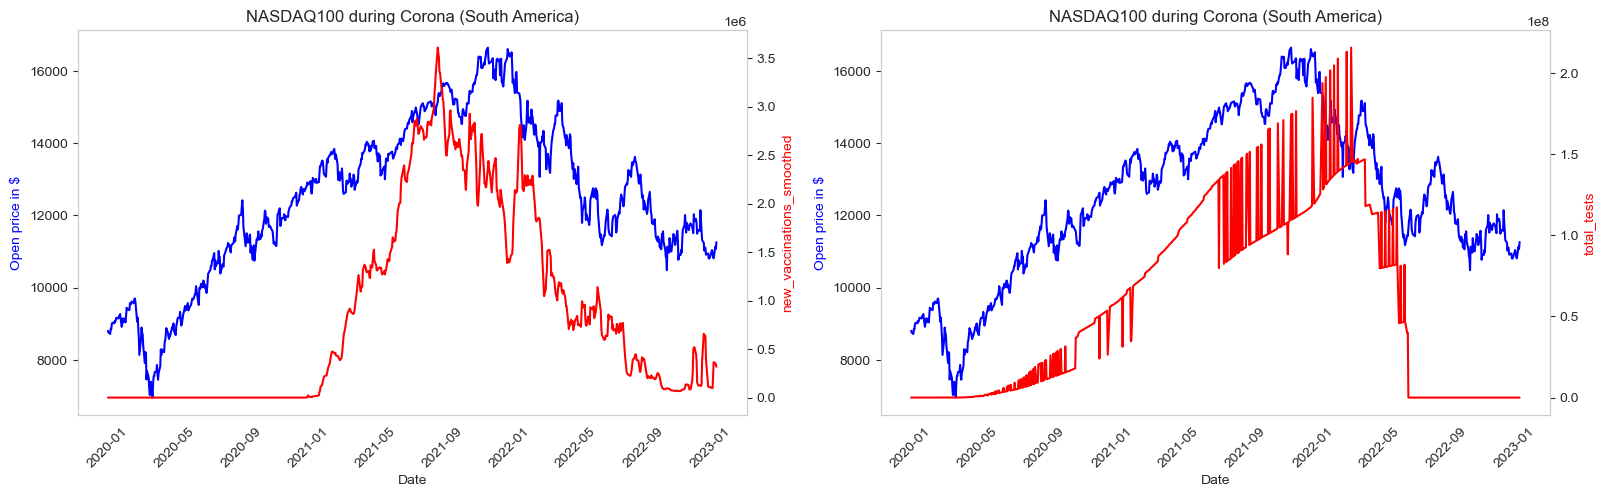

In [41]:
nasdaq_correlation_and_regression(nasdaq100_dataset, continent="South America", title="NASDAQ100 during Corona (South America)")

Correlations with Open nasdaq value and new_vaccinations_smoothed: 0.7135930292181332
Highest correlations with Open nasdaq value: (cardiovasc_death_rate) 0.8197809563307606

RandomForestRegressor:
MSE: 738.7402466682433, SCORE: 0.8324989470680645


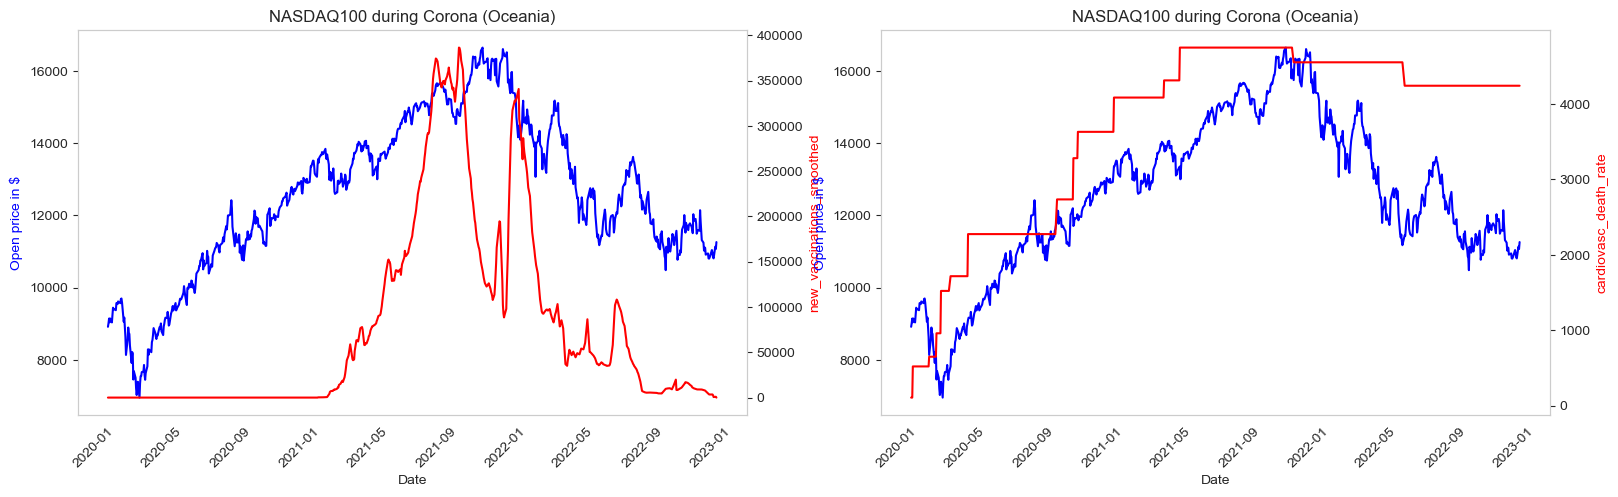

In [42]:
nasdaq_correlation_and_regression(nasdaq100_dataset, continent="Oceania", title="NASDAQ100 during Corona (Oceania)")

## Homicides during Corona

Text(0.5, 1.0, 'Homicides in London')

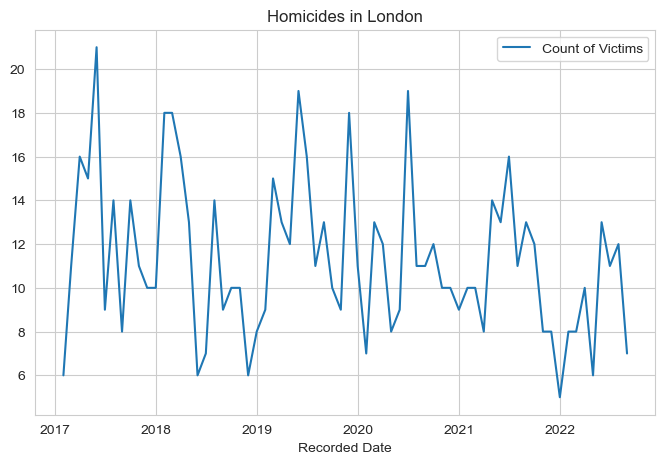

In [43]:
sns.lineplot(data=homicide_dataset[homicide_dataset.index > pd.to_datetime("2017-01-01")])
plt.title("Homicides in London")

In [44]:
homicide_dataset

Count of Victims
Recorded Date                  
2003-01-01                   18
2003-02-01                   16
2003-03-01                   20
2003-04-01                   14
2003-05-01                   16
...                         ...
2022-05-01                    6
2022-06-01                   13
2022-07-01                   11
2022-08-01                   12
2022-09-01                    7

[237 rows x 1 columns]

In [45]:
covid_homicide_dataset = \
    homicide_dataset.join(covid_dataset.groupby("date").sum(numeric_only=True), on="Recorded Date")[
        homicide_dataset.index > pd.to_datetime("2020-04-01")]
covid_homicide_dataset

Count of Victims   total_cases   new_cases  new_cases_smoothed  \
Recorded Date                                                                   
2020-05-01                    8  1.447492e+07    364923.0        3.259934e+05   
2020-06-01                    9  2.628912e+07    404037.0        4.470819e+05   
2020-07-01                   19  4.403818e+07    864929.0        7.291777e+05   
2020-08-01                   11  7.281194e+07    990724.0        1.034411e+06   
2020-09-01                   11  1.051461e+08   1087836.0        1.087674e+06   
2020-10-01                   12  1.403733e+08   1324115.0        1.214159e+06   
2020-11-01                   10  1.929106e+08   1921536.0        2.199697e+06   
2020-12-01                   10  2.678508e+08   2578129.0        2.486650e+06   
2021-01-01                    9  3.530416e+08   2371052.0        2.546727e+06   
2021-02-01                   10  4.349507e+08   1897549.0        2.253856e+06   
2021-03-01                   10  4.823014e+08   1295496.0        1.678426e+06   
2021-04-01                    8  5.474813e+08   3044978.0        2.525120e+06   
2021-05-01                   14  6.418904e+08   3272147.0        3.381569e+06   
2021-06-01                   13  7.193275e+08   1870157.0        1.942216e+06   
2021-07-01                   16  7.656526e+08   1767416.0        1.524235e+06   
2021-08-01                   11  8.301867e+08   1967739.0        2.453248e+06   
2021-09-01                   13  9.127326e+08   2960754.0        2.632492e+06   
2021-10-01                   12  9.776854e+08   2144775.0        1.858301e+06   
2021-11-01                    8  1.032075e+09   1949355.0        1.880030e+06   
2021-12-01                    8  1.102027e+09   3116768.0        2.584932e+06   
2022-01-01                    5  1.216281e+09   5331678.0        6.120859e+06   
2022-02-01                    8  1.618047e+09  13853757.0        1.383393e+07   
2022-03-01                    8  1.865233e+09   6915577.0        6.702339e+06   
2022-04-01                   10  2.088067e+09   6330044.0        6.388422e+06   
2022-05-01                    6  2.194899e+09   1344998.0        2.652548e+06   
2022-06-01                   13  2.266560e+09   2978995.0        2.035544e+06   
2022-07-01                   11  2.345069e+09   4262229.0        3.404155e+06   
2022-08-01                   12  2.473609e+09   3703636.0        4.306688e+06   
2022-09-01                    7  2.580244e+09   2838493.0        2.573311e+06   

               total_deaths  new_deaths  new_deaths_smoothed  \
Recorded Date                                                  
2020-05-01        1141394.0     23456.0            25432.577   
2020-06-01        1766229.0     15156.0            18385.437   
2020-07-01        2363020.0     21512.0            19107.290   
2020-08-01        3074674.0     24118.0            24471.291   
2020-09-01        3813024.0     26671.0            22892.859   
2020-10-01        4504826.0     36006.0            23704.576   
2020-11-01        5260326.0     22701.0            28766.432   
2020-12-01        6501052.0     54001.0            45323.719   
2021-01-01        8018102.0     40403.0            48421.860   
2021-02-01        9809192.0     43665.0            60391.714   
2021-03-01       11117128.0     32267.0            41192.285   
2021-04-01       12408932.0     51948.0            45976.141   
2021-05-01       13999438.0     53867.0            57210.860   
2021-06-01       15562003.0     44491.0            44282.715   
2021-07-01       16682612.0     34431.0            31970.289   
2021-08-01       17762343.0     29731.0            37056.137   
2021-09-01       18995721.0     50208.0            39798.007   
2021-10-01       20058363.0     35178.0            31995.710   
2021-11-01       20946808.0     27169.0            30172.714   
2021-12-01       21873174.0     39311.0            30833.435   
2022-01-01       22801345.0     18138.0            26832.008   
2022-02-01       23843661.0    

In [46]:
covid_homicide_dataset.corr()["Count of Victims"].sort_values()

hosp_patients_per_million                    -0.443942
weekly_hosp_admissions_per_million           -0.436799
weekly_hosp_admissions                       -0.419286
hosp_patients                                -0.401184
new_cases_smoothed_per_million               -0.355502
                                                ...   
stringency_index                              0.157879
new_people_vaccinated_smoothed                0.183524
tests_per_case                                0.209269
new_people_vaccinated_smoothed_per_hundred    0.215070
Count of Victims                              1.000000
Name: Count of Victims, Length: 63, dtype: float64

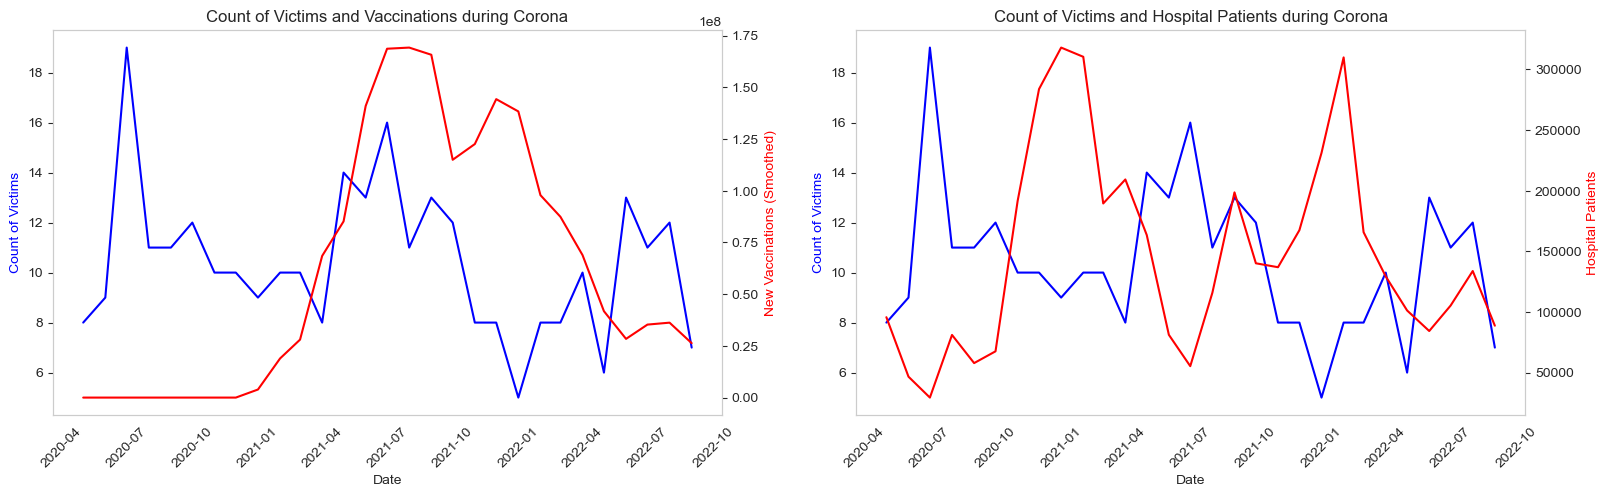

In [47]:
plt.rcParams["figure.figsize"] = (19,5)
plt.subplot(1, 2, 1)
double_plot("Count of Victims and Vaccinations during Corona", 'Date', 'Count of Victims', "New Vaccinations (Smoothed)",
                    covid_homicide_dataset["Count of Victims"],
                    covid_homicide_dataset["new_vaccinations_smoothed"])

plt.subplot(1, 2, 2)
double_plot("Count of Victims and Hospital Patients during Corona", 'Date', 'Count of Victims', "Hospital Patients",
                    covid_homicide_dataset["Count of Victims"],
                    covid_homicide_dataset["hosp_patients"])

plt.rcParams["figure.figsize"] = (8,5)

In [48]:
air_berlin_dataset_grouped = air_berlin_dataset.set_index('Date').groupby(pd.Grouper(freq='d')).mean().dropna(how='all')
air_berlin_dataset_grouped = air_berlin_dataset_grouped.join(covid_dataset.groupby("date").sum(numeric_only=True))[
    air_berlin_dataset_grouped.index > pd.to_datetime("2020-04-01")]

C:\Users\Larsk\AppData\Local\Temp\ipykernel_20148\2480214709.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  air_berlin_dataset_grouped = air_berlin_dataset.set_index('Date').groupby(pd.Grouper(freq='d')).mean().dropna(how='all')


In [49]:
grouped_flight_dataset = flight_dataset.groupby(by="date").sum()
covid_flight_dataset = grouped_flight_dataset.join(covid_dataset.groupby("date").sum(numeric_only=True), on="date")[
    grouped_flight_dataset.index > pd.to_datetime("2020-04-01")]

C:\Users\Larsk\AppData\Local\Temp\ipykernel_20148\2547205743.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_flight_dataset = flight_dataset.groupby(by="date").sum()


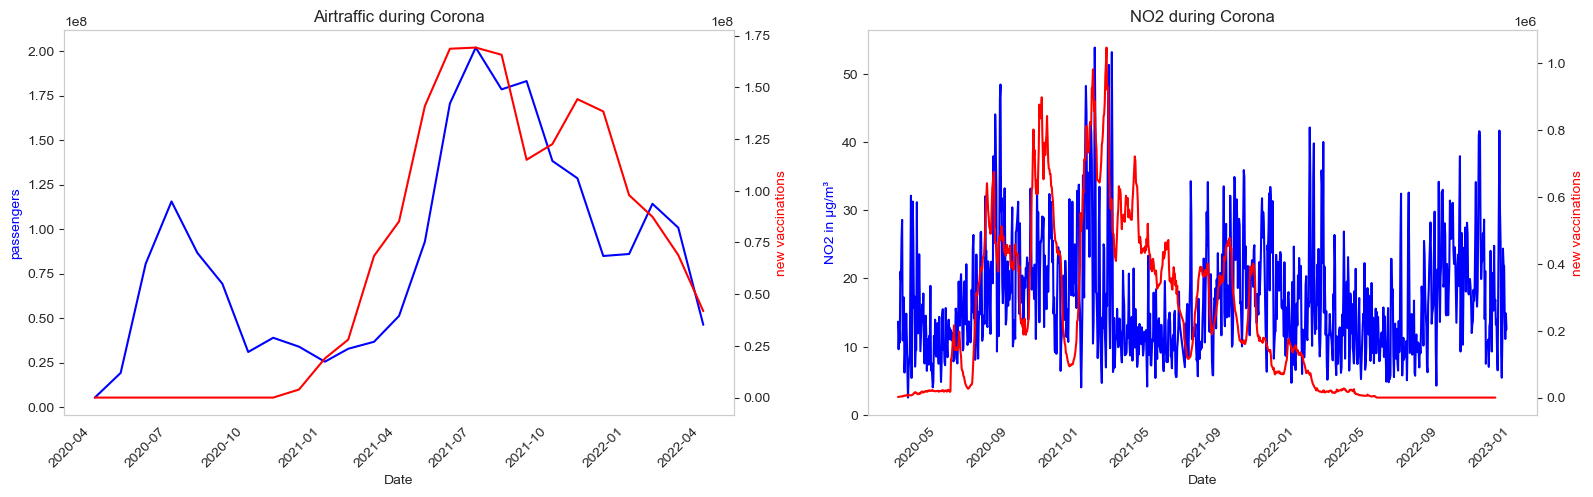

In [50]:
plt.rcParams["figure.figsize"] = (19,5)
plt.subplot(1, 2, 1)

double_plot("Airtraffic during Corona", 'Date', 'passengers', 'new vaccinations', covid_flight_dataset["passengers"],
            covid_flight_dataset["new_vaccinations_smoothed"])

plt.subplot(1, 2, 2)
double_plot("NO2 during Corona", 'Date', 'NO2 in µg/m³', 'new vaccinations',
            air_berlin_dataset_grouped["Nitrogen dioxide (NO₂) One hour average in µg/m³"],
            air_berlin_dataset_grouped["tests_per_case"])
plt.rcParams["figure.figsize"] = (8,5)

In [51]:
covid_flight_dataset = grouped_flight_dataset.join(covid_dataset.groupby("date").sum(numeric_only=True), on="date")[
    grouped_flight_dataset.index > pd.to_datetime("2020-04-01")]
covid_flight_dataset

year   passengers   total_cases   new_cases  new_cases_smoothed  \
date                                                                            
2020-05-01  212100    5319068.0  1.447492e+07    364923.0        3.259934e+05   
2020-06-01  212100   19180718.0  2.628912e+07    404037.0        4.470819e+05   
2020-07-01  212100   80474532.0  4.403818e+07    864929.0        7.291777e+05   
2020-08-01  212100  115483836.0  7.281194e+07    990724.0        1.034411e+06   
2020-09-01  212100   86609152.0  1.051461e+08   1087836.0        1.087674e+06   
2020-10-01  212100   69279624.0  1.403733e+08   1324115.0        1.214159e+06   
2020-11-01  212100   30935082.0  1.929106e+08   1921536.0        2.199697e+06   
2020-12-01  212100   38923434.0  2.678508e+08   2578129.0        2.486650e+06   
2021-01-01  212205   33908696.0  3.530416e+08   2371052.0        2.546727e+06   
2021-02-01  212205   25473660.0  4.349507e+08   1897549.0        2.253856e+06   
2021-03-01  212205   32737864.0  4.823014e+08   1295496.0        1.678426e+06   
2021-04-01  212205   36664690.0  5.474813e+08   3044978.0        2.525120e+06   
2021-05-01  212205   51205376.0  6.418904e+08   3272147.0        3.381569e+06   
2021-06-01  212205   92967684.0  7.193275e+08   1870157.0        1.942216e+06   
2021-07-01  212205  170492822.0  7.656526e+08   1767416.0        1.524235e+06   
2021-08-01  212205  201922156.0  8.301867e+08   1967739.0        2.453248e+06   
2021-09-01  212205  178458944.0  9.127326e+08   2960754.0        2.632492e+06   
2021-10-01  212205  183105174.0  9.776854e+08   2144775.0        1.858301e+06   
2021-11-01  212205  138223290.0  1.032075e+09   1949355.0        1.880030e+06   
2021-12-01  212205  128515848.0  1.102027e+09   3116768.0        2.584932e+06   
2022-01-01  212310   84863740.0  1.216281e+09   5331678.0        6.120859e+06   
2022-02-01  212310   85975760.0  1.618047e+09  13853757.0        1.383393e+07   
2022-03-01  212310  114171904.0  1.865233e+09   6915577.0        6.702339e+06   
2022-04-01  212310  100741528.0  2.088067e+09   6330044.0        6.388422e+06   
2022-05-01  212310   46187366.0  2.194899e+09   1344998.0        2.652548e+06   

            total_deaths  new_deaths  new_deaths_smoothed  \
date                                                        
2020-05-01     1141394.0     23456.0            25432.577   
2020-06-01     1766229.0     15156.0            18385.437   
2020-07-01     2363020.0     21512.0            19107.290   
2020-08-01     3074674.0     24118.0            24471.291   
2020-09-01     3813024.0     26671.0            22892.859   
2020-10-01     4504826.0     36006.0            23704.576   
2020-11-01     5260326.0     22701.0            28766.432   
2020-12-01     6501052.0     54001.0            45323.719   
2021-01-01     8018102.0     40403.0            48421.860   
2021-02-01     9809192.0     43665.0            60391.714   
2021-03-01    11117128.0     32267.0            41192.285   
2021-04-01    12408932.0     51948.0            45976.141   
2021-05-01    13999438.0     53867.0            57210.860   
2021-06-01    15562003.0     44491.0            44282.715   
2021-07-01    16682612.0     34431.0            31970.289   
2021-08-01    17762343.0     29731.0            37056.137   
2021-09-01    18995721.0     50208.0            39798.007   
2021-10-01    20058363.0     35178.0            31995.710   
2021-11-01    20946808.0     27169.0            30172.714   
2021-12-01    21873174.0     39311.0            30833.435   
2022-01-01    22801345.0     18138.0            26832.008   
2022-02-01    23843661.0     52331.0            41462.434   
2022-03-01    24994772.0     36181.0            35511.716   
2022-04-01    25784102.0     19477.0            17356.865   
2022-05-01    26141977.0      5046.0            10921.005   

            total_cases_per_million  new_cases_per_million  ...  male_smokers  \
date                                                        ...                 
2020-05-01      

In [52]:
covid_flight_dataset.corr()["passengers"].sort_values()

stringency_index                    -0.391147
weekly_icu_admissions_per_million   -0.352978
hosp_patients_per_million           -0.332396
icu_patients_per_million            -0.329423
weekly_icu_admissions               -0.305088
                                       ...   
population_density                   0.721832
new_vaccinations                     0.724020
new_vaccinations_smoothed            0.765321
new_people_vaccinated_smoothed       0.818677
passengers                           1.000000
Name: passengers, Length: 64, dtype: float64

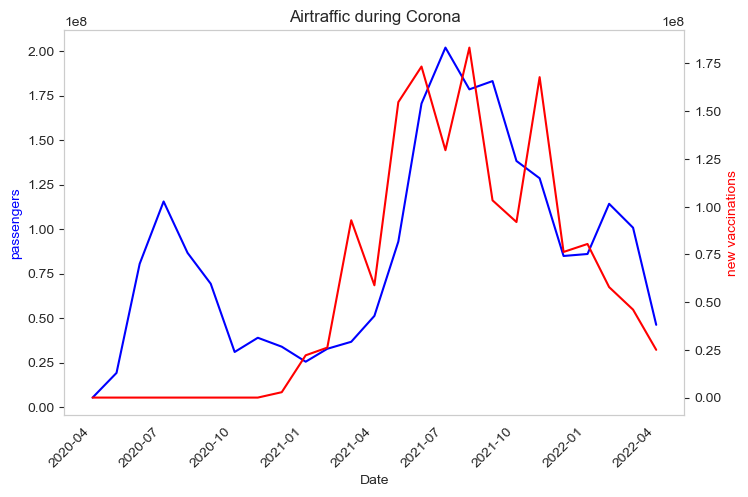

In [53]:
double_plot("Airtraffic during Corona", 'Date', 'passengers', 'new vaccinations', covid_flight_dataset["passengers"],
            covid_flight_dataset["new_vaccinations"])

In [54]:
air_berlin_dataset_grouped

Particulate matter (PM₁₀) floating hourly daily average in µg/m³  \
Date                                                                           
2020-04-02                                          12.250000                  
2020-04-03                                          18.000000                  
2020-04-04                                          12.291667                  
2020-04-05                                          19.416667                  
2020-04-06                                          24.708333                  
...                                                       ...                  
2023-01-26                                          19.416667                  
2023-01-27                                          13.666667                  
2023-01-28                                           9.833333                  
2023-01-29                                          14.708333                  
2023-01-30                                          16.105263                  

            Ozone (O₃) One hour average in µg/m³  \
Date                                               
2020-04-02                                   NaN   
2020-04-03                                   NaN   
2020-04-04                                   NaN   
2020-04-05                                   NaN   
2020-04-06                                   NaN   
...                                          ...   
2023-01-26                                   NaN   
2023-01-27                                   NaN   
2023-01-28                                   NaN   
2023-01-29                                   NaN   
2023-01-30                                   NaN   

            Nitrogen dioxide (NO₂) One hour average in µg/m³  total_cases  \
Date                                                                        
2020-04-02                                         13.666667    4595041.0   
2020-04-03                                          9.625000    4962351.0   
2020-04-04                                         12.333333    5210218.0   
2020-04-05                                         10.583333    5519381.0   
2020-04-06                                         21.000000    5837859.0   
...                                                      ...          ...   
2023-01-26                                         21.791667          NaN   
2023-01-27                                         14.375000          NaN   
2023-01-28                                         11.125000          NaN   
2023-01-29                                         14.875000          NaN   
2023-01-30                                         12.526316          NaN   

            new_cases  new_cases_smoothed  total_deaths  new_deaths  \
Date                                                                  
2020-04-02   357294.0          315398.720      274819.0     27998.0   
2020-04-03   367310.0          327155.574      304223.0     29404.0   
2020-04-04   333251.0          326682.148      332489.0     29426.0   
2020-04-05   309163.0          338790.432      358546.0     26057.0   
2020-04-06   318478.0          343437.425      387023.0     28477.0   
...               ...                 ...           ...         ...   
2023-01-26        NaN                 NaN           NaN         NaN   
2023-01-27        NaN                 NaN           NaN         NaN   
2023-01-28        NaN                 NaN           NaN         NaN   
2023-01-29        NaN                 NaN           NaN         NaN   
2023-01-30        NaN                 NaN           NaN         NaN   

            new_deaths_smoothed  total_cases_per_million  ...  male_smokers  \
Date                                                      ...                 
2020-04-02            22072.861                75260.089  ...      4429.735   
2020-04-03            23865.578                79519.835  ...      4429.735   
2020-04-04            25357.286                83212

In [55]:
air_berlin_dataset_grouped.corr()["Nitrogen dioxide (NO₂) One hour average in µg/m³"].sort_values()["new_vaccinations_smoothed"]

-0.08651753418064304

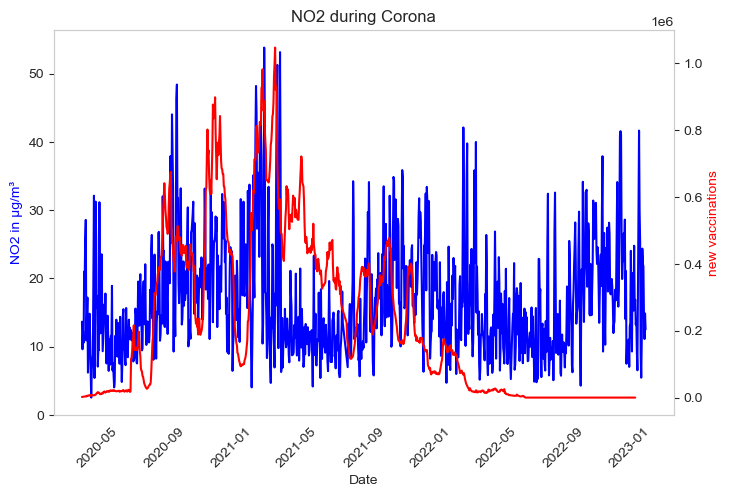

In [56]:
double_plot("NO2 during Corona", 'Date', 'NO2 in µg/m³', 'new vaccinations',
            air_berlin_dataset_grouped["Nitrogen dioxide (NO₂) One hour average in µg/m³"],
            air_berlin_dataset_grouped["tests_per_case"])